# Streamlined testing for word embeddings

In [1]:
import numpy as np
import pandas as pd
from numpy import linalg
import fasttext.util
from gensim.models.fasttext import FastText, load_facebook_vectors, load_facebook_model
from gensim.models import KeyedVectors

from tqdm import tqdm
import random
import string
random_state = 1
random.seed(random_state) 



unable to import 'smart_open.gcs', disabling that module


In [2]:

%load_ext autoreload
%autoreload 2
import json
import bias_neighbors as bias_neighbors
import bias_projection as bias_projection
import Utils_R as util_r
import WEAT
import debias_weat as debias_weat
from relation import Relation
import pickle

In [3]:
#visualize imports
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline
mpl.rc("savefig", dpi=200)
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.prop_cycle'] = cycler(color='rc')
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

## Load models
Methods used to load different combinations of models 

In [4]:
embed_path = "../Rodrigo-data/Embeddings/"

In [5]:
def load_fasttext(debiased = False, model_name = 'fasttext_320'):
    load_path = embed_path+'FastText/'
    model_fast = load_facebook_vectors(load_path+model_name+".bin")# old name -> "cc.nl.300_fasttext.bin")    
    model_fast_debiased = KeyedVectors.load(load_path+"Debiased/"+model_name+".model") if debiased else None
    return [{"model":model_fast,"vec_len":300,"name":model_name,"model_debiased":model_fast_debiased,"load_path":load_path}]

In [6]:
def load_cow(debiased = False, model_name_small = 'cow-320', model_name_big = 'cow-big', big=True, small=True):
    load_path = embed_path+'Clips/COW/'
    model_cow_small = KeyedVectors.load_word2vec_format(load_path+model_name_small+".txt", binary=False,unicode_errors='replace') if small else None# uncomment if there is some problem when using embedding,limit = 603304) #from txt?
    model_cow_big = KeyedVectors.load_word2vec_format(load_path+model_name_big+".txt", binary=False,unicode_errors='replace') if big else None


    model_cow_small_debiased = KeyedVectors.load(load_path+"/Debiased/"+model_name_small+".model") if small and debiased else None   
    model_cow_big_debiased = KeyedVectors.load(load_path+"/Debiased/"+model_name_big+".model") if big and debiased else None

    return [
            {"model":model_cow_small,"vec_len":320,"name":model_name_small,"model_debiased":model_cow_small_debiased,"load_path":load_path},
            {"model":model_cow_big,"vec_len":320,"name":model_name_big,"model_debiased":model_cow_big_debiased,"load_path":load_path}]

In [7]:
def load_sonar(debiased = False, model_name_160 = 'sonar-160', model_name_320 = 'sonar-320', big=True, small=True):
    load_path = embed_path+'Clips/Sonar/'
    model_sonar_160 = KeyedVectors.load_word2vec_format(load_path+model_name_160+".txt", binary=False,unicode_errors='replace') if small else None# uncomment if there is some problem when using embedding,limit = 603304) #from txt?
    model_sonar_320 = KeyedVectors.load_word2vec_format(load_path+model_name_320+".txt", binary=False,unicode_errors='replace') if big else None


    model_sonar_160_debiased = KeyedVectors.load(load_path+"/Debiased/"+model_name_160+".model") if small and debiased else None   
    model_sonar_320_debiased = KeyedVectors.load(load_path+"/Debiased/"+model_name_320+".model") if big and debiased else None

    return [
            {"model":model_sonar_160,"vec_len":160,"name":model_name_160,"model_debiased":model_sonar_160_debiased,"load_path":load_path},
            {"model":model_sonar_320,"vec_len":320,"name":model_name_320,"model_debiased":model_sonar_320_debiased,"load_path":load_path}]

In [8]:
def load_nlpl(debiased = False, model_name = 'model_nlpl'):
    load_path = embed_path+'NLPL/'
    
    model_nlpl = KeyedVectors.load_word2vec_format(load_path+model_name+".bin", binary=True)  
    model_nlpl_debiased = KeyedVectors.load(load_path+ "Debiased/"+ model_name+".model")  if debiased else None

    return [{"model":model_nlpl,"vec_len":100,"name":model_name,"model_debiased":model_nlpl_debiased,"load_path":load_path}]

# Main
The main code with functions and other stuff goes down here.

## Projection steps

In [9]:
def projection_bias_steps(vocab_limited, wv_limited,  model, gender_bias_projection, model_debiased):
    """ Encapsulates the steps related to the projection method.
            1. Compute bias projection.
            2. Encode lists of male & female words.
            3. Generate 2 clusters by using KMeans.
                - Get cluster statistic based on how accurate we can separate male and female words. 

    Parameters:
        UNUSED vocab_limited (list[word]): vocab of model without excluded words (gender specific words).
        UNUSED wv_limited (list[i,vector]): the vectors corresponding to the vocab_limited list.
        model : current model from gensim.
        gender_bias_projection : 
    """    
    size = 500   
    male, female = bias_projection.get_male_and_female_lists(gender_bias_projection, size)  
    male_female = male + female
    y_true = [0]*size + [1]*size 
    X_orig = bias_projection.extract_vectors(male_female, model)#get bias and debiased here
    X_debiased = bias_projection.extract_vectors(male_female, model_debiased)
    
    cluster_metric_a = bias_projection.cluster_and_visualize(male_female, X_orig, X_debiased, random_state, y_true)
    return cluster_metric_a, male, female


## Pipeline

In [10]:
def compute_all_tests(model,model_vec_len, model_name, exclude_words,cluster_results, downstream_results, model_debiased = None):
    """
    Parameters:
    cluster_results: Referenced dict, modify in place and reuse per every model. No need to use return.
    """
    print("----------------Processing new model!------------------------------------------------------")
    print("NAME:",model_name)
    results_weat = -1 #dummy value
    # get the embeddings without the excluded words to make the analysis -R
    vocab_limited, wv_limited = util_r.limit_vocab(model, exclude = exclude_words, vec_len=model_vec_len)
    ########################################################################################################
    # compute bias-by-projection before and after debiasing
    gender_bias_projection = bias_projection.compute_bias_by_projection(wv_limited, vocab_limited, model)
    bias_projection.report_bias(gender_bias_projection) 
    ########################################################################################################
    up_name = model_name.upper()
    print("PROJECTION STEP:",up_name)    
    #Projection 
    cluster_metric_a, male, female = projection_bias_steps(vocab_limited, wv_limited, model, gender_bias_projection, model_debiased)
    cluster_results[model_name] = cluster_metric_a    
    print('Cluster metric results: [orig,debiased] ',cluster_metric_a)
    # cluster_results[model_name+' debiased'] = cluster_metric_a[1]
    ################################################################################################################
    #WEAT
    # print("WEAT ORIGINAL STEP:",up_name)    
    # results_weat = WEAT.WEAT_Test(model, model_name,verbose=False)
    # results_weat_2 = results_weat.copy()
    # print("WEAT DEBIASED STEP:",up_name)             
    # results_weat_debiased = WEAT.WEAT_Test(model_debiased, model_name+'_debiased',verbose=False)
    # results_weat_debiased.drop(['Model','XYAB'], axis=1,inplace=True)
    # ########################################################################################################
    # print("LATEX:")
    # latex_ = util_r.create_latex_table_weat(results_weat_2,results_weat_debiased)
    # save_latex = '../Rodrigo-data/Results/Latex_tables/latex_'+model_name+'.txt'
    # print(latex_,file=open(save_latex, 'w'))
    # ########################################################################################################
    # #Downstream task
    # print("(LONG WAIT)DOWNSTREAM STEP:",up_name)    
    # questions_task = "WEAT_clips/data/question-words.txt"
    # biased_down = Relation(questions_task).test_model_2020(model)
    # debiased_down = Relation(questions_task).test_model_2020(model_debiased)
    # downstream_results[model_name] = [biased_down[0],debiased_down[0]]       
    # print('Downstream biased:',biased_down[0])
    # print('Downstream debiased:',debiased_down[0])
    # pickle_path= '../Rodrigo-data/Results/downstream_pickle/'
    # pickle.dump(biased_down, open( pickle_path+model_name+"_biased.p", "wb" ) ) #save for later processing
    # pickle.dump(debiased_down, open( pickle_path+model_name+"_debiased.p", "wb" ) )
    ########################################################################################################
    print("END of model:", up_name)
    return male, female


In [11]:
# #SAVE PICKE
# """SAVE PICKLE"""
# modedl_name = 'testtt'
# pickle_path= '../Rodrigo-data/Results/downstream_pickle/'
# biased_down = ['a','b']
# pickle.dump(biased_down, open(pickle_path+modedl_name+"_biased.p", "wb" ) )
# # pickle.dump(debiased_down, open( pickle_path+modedl_name+"_debiased.p", "wb" ) )

In [12]:
# #LOAD PICKE
# """LOAD PICKLE"""
# favorite_color = pickle.load(open(pickle_path+modedl_name+"_biased.p", "rb" ) )
# favorite_color

# Call functions


In [13]:
exclude_words =         debias_weat.load_gender_specific_words() 
gender_specific_words = debias_weat.load_gender_specific_words()
defs, equalize_pairs =  debias_weat.load_def_and_equ_words()

In [14]:
cluster_1817 = {}
downstream_1817 = {}
debias_save_models = True

100%|██████████| 50000/50000 [00:00<00:00, 565504.82it/s]----------------Processing new model!------------------------------------------------------
NAME: fasttext_320
size of vocabulary: 26171

Report bias by projection: 0.11543014155665182
PROJECTION STEP: FASTTEXT_320
30 init clustering
ORIGINAL: Model Results cluster_visualize
ORIGINAL: Precision 0.611
ORIGINAL: Neighborhood Metric (closer to .5 is better) 0.611
DEBIASED: Model Results cluster_visualize
DEBIASED: Precision 0.605
DEBIASED: Neighborhood Metric (closer to .5 is better) 0.605
Cluster metric results: [orig,debiased]  [0.611, 0.605]
END of model: FASTTEXT_320
RESULTS WEAT
ACTUALLY END................................................................................


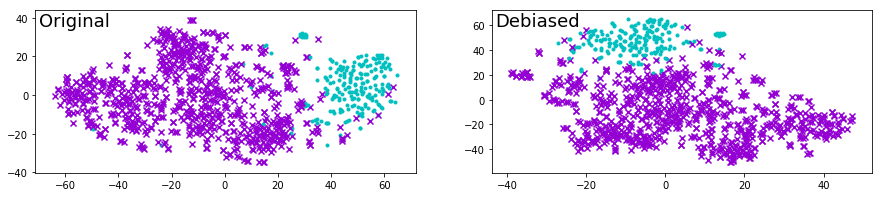

In [15]:
if debias_save_models:
    models = None
    models = load_fasttext(True)  #biggest bottleneck
    for model_info in models:
        male, female  = compute_all_tests(model_info['model'],model_info['vec_len'],model_info['name'], exclude_words, cluster_1817, downstream_1817, model_info['model_debiased'])
        print("RESULTS WEAT")
        # print(res_weat)
        print("ACTUALLY END................................................................................")
        model_info = None #free memory
        pairs = {'male':male,'female':female}
        pd.DataFrame(pairs).to_csv('../Rodrigo-data/clustering_testing_july20th/final_top500biased_pairs_fasttext.csv')

100%|██████████| 50000/50000 [00:00<00:00, 356241.07it/s]----------------Processing new model!------------------------------------------------------
NAME: cow-320
size of vocabulary: 48834

Report bias by projection: 0.04150913317099685
PROJECTION STEP: COW-320
30 init clustering
ORIGINAL: Model Results cluster_visualize
ORIGINAL: Precision 1.0
ORIGINAL: Neighborhood Metric (closer to .5 is better) 1.0
100%|██████████| 50000/50000 [00:00<00:00, 351407.71it/s]DEBIASED: Model Results cluster_visualize
DEBIASED: Precision 1.0
DEBIASED: Neighborhood Metric (closer to .5 is better) 1.0
Cluster metric results: [orig,debiased]  [1.0, 1.0]
END of model: COW-320
RESULTS WEAT
ACTUALLY END................................................................................
----------------Processing new model!------------------------------------------------------
NAME: cow-big
size of vocabulary: 48834

Report bias by projection: 0.0389166925586483
PROJECTION STEP: COW-BIG
30 init clustering
ORIGINAL:

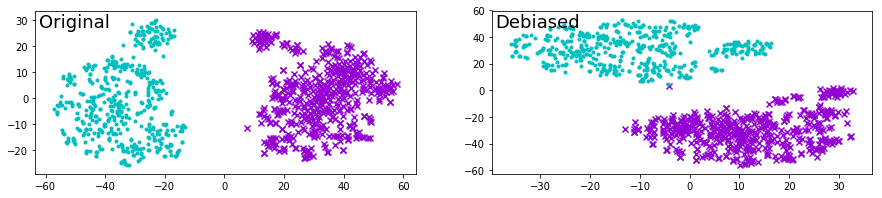

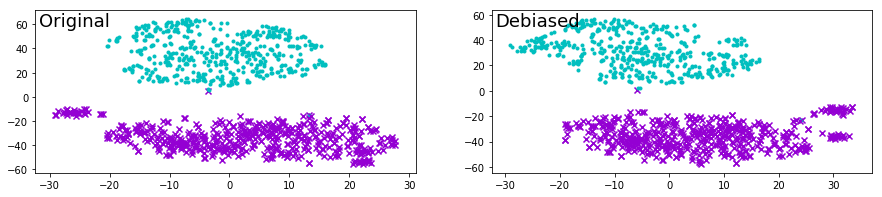

In [16]:
if debias_save_models:
    models = None
    models = load_cow(True)  #biggest bottleneck
    for model_info in models:
        male, female  = compute_all_tests(model_info['model'],model_info['vec_len'],model_info['name'], exclude_words, cluster_1817, downstream_1817, model_info['model_debiased'])
        print("RESULTS WEAT")
        # print(res_weat)
        print("ACTUALLY END................................................................................")
        model_info = None #free memory
        pairs = {'male':male,'female':female}
        pd.DataFrame(pairs).to_csv('../Rodrigo-data/clustering_testing_july20th/final_top500biased_pairs_cow.csv')


100%|██████████| 50000/50000 [00:00<00:00, 355007.24it/s]----------------Processing new model!------------------------------------------------------
NAME: sonar-160
size of vocabulary: 49505

Report bias by projection: 0.031208526973765777
PROJECTION STEP: SONAR-160
30 init clustering
ORIGINAL: Model Results cluster_visualize
ORIGINAL: Precision 1.0
ORIGINAL: Neighborhood Metric (closer to .5 is better) 1.0
100%|██████████| 50000/50000 [00:00<00:00, 346189.79it/s]DEBIASED: Model Results cluster_visualize
DEBIASED: Precision 1.0
DEBIASED: Neighborhood Metric (closer to .5 is better) 1.0
Cluster metric results: [orig,debiased]  [1.0, 1.0]
END of model: SONAR-160
RESULTS WEAT
ACTUALLY END................................................................................
----------------Processing new model!------------------------------------------------------
NAME: sonar-320
size of vocabulary: 49505

Report bias by projection: 0.028682630164087636
PROJECTION STEP: SONAR-320
30 init cluster

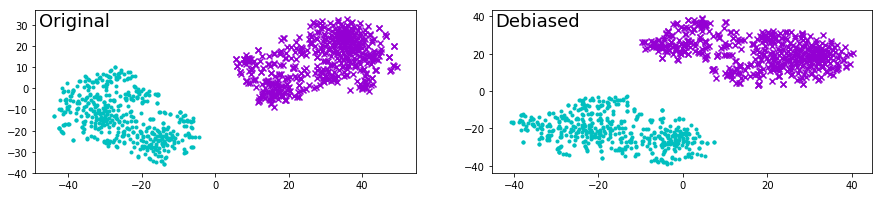

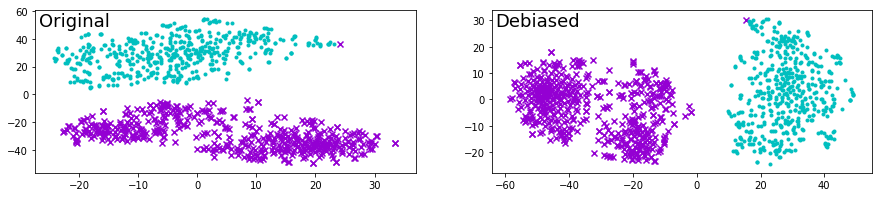

In [17]:
if debias_save_models:
    models = None
    models = load_sonar(True)  #biggest bottleneck
    for model_info in models:
        male, female  = compute_all_tests(model_info['model'],model_info['vec_len'],model_info['name'], exclude_words, cluster_1817, downstream_1817, model_info['model_debiased'])
        print("RESULTS WEAT")
        # print(res_weat)
        print("ACTUALLY END................................................................................")
        model_info = None #free memory
        pairs = {'male':male,'female':female}
        pd.DataFrame(pairs).to_csv('../Rodrigo-data/clustering_testing_july20th/final_top500biased_pairs_sonar.csv')

100%|██████████| 50000/50000 [00:00<00:00, 375308.39it/s]----------------Processing new model!------------------------------------------------------
NAME: model_nlpl
size of vocabulary: 43768

Report bias by projection: 0.6702604322506507
PROJECTION STEP: MODEL_NLPL
30 init clustering
ORIGINAL: Model Results cluster_visualize
ORIGINAL: Precision 0.999
ORIGINAL: Neighborhood Metric (closer to .5 is better) 0.999
DEBIASED: Model Results cluster_visualize
DEBIASED: Precision 0.995
DEBIASED: Neighborhood Metric (closer to .5 is better) 0.995
Cluster metric results: [orig,debiased]  [0.999, 0.995]
END of model: MODEL_NLPL
RESULTS WEAT
ACTUALLY END................................................................................


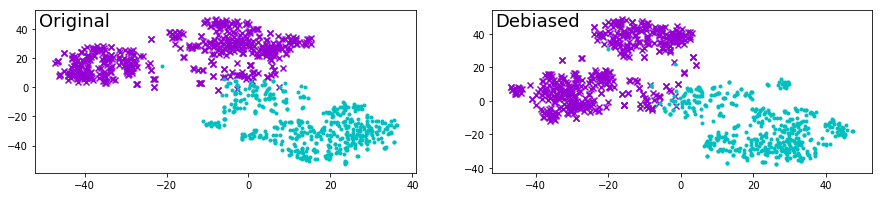

In [18]:
male, female = [],[]
if debias_save_models:
    models = None
    models = load_nlpl(True)  #biggest bottleneck
    for model_info in models:
        male, female = compute_all_tests(model_info['model'],model_info['vec_len'],model_info['name'], exclude_words, cluster_1817, downstream_1817, model_info['model_debiased'])
        print("RESULTS WEAT")
        
        pairs = {'male':male,'female':female}
        pd.DataFrame(pairs).to_csv('../Rodrigo-data/clustering_testing_july20th/final_top500biased_pairs_nlpl.csv')
        # print(res_weat)
        print("ACTUALLY END................................................................................")
        # model_info = None #free memory

In [19]:
print(male)

['successfully', 'beerschot', 'criminal', 'skills', 'guests', 'guard', 'bit', 'moeskroen', 'bots', 'br', 'soldier', 'cambuur', 'wtc', 'granaten', 'swansea', 'eindronde', 'eredivisie', 'run', 'turn', 'wedstrijden', 'bekertoernooi', 'sheikh', 'poule', 'counter', 'ploegen', 'ismail', 'winterstop', 'voetbalvelden', 'scouts', 'basisplaats', 'ohl', 'dijks', 'signal', 'nor', 'sli', 'drum', 'further', 'windkracht', 'africa', 'uitwedstrijd', 'fail', 'ebecilio', 'crossing', 'doelpunt', 'huurbasis', 'uitzenddatum', 'bale', 'guns', 'combat', 'also', 'besiktas', 'persie', 'speeldagen', 'egypt', 'dinamo', 'packets', 'establishment', 'exodus', 'fury', 'kv', 'campaign', 'built', 'scheidsrechters', 'schellevis', 'rangers', 'charge', 'jurian', 'move', 'hsv', 'lieutenant', 'oberliga', 'jc', 'level', 'narsingh', 'xavi', 'driver', 'arab', 'said', 'bataljon', 'ahmadinejad', 'dagenafgelopen', 'berichtentop', 'excelsior', 'scheids', 'siege', 'bunkers', 'territory', 'username', 'colonel', 'kamen', 'copied', 'r

In [20]:
pairs = {'male':male,'female':female}
pd.DataFrame(pairs).to_csv('../Rodrigo-data/clustering_testing_july20th/top500biased_pairs_nlpl_norm.csv')

In [21]:
# d_res_latex = util_r.create_latex_table_downstream(downstream_1817)
# print(d_res_latex)
# c_res_latex = util_r.create_latex_table_cluster(cluster_1817)
# print(c_res_latex)